# Rhode Island Scraper from Google Sheet/CSV

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import zipfile
import pandas as pd
from io import StringIO
import requests
import csv
import time
import random
import matplotlib.pyplot as plt

## Creating Dataframe by exporting GSheet as CSV

In [2]:
# original link ->https://docs.google.com/spreadsheets/d/1c2QrNMz8pIbYEKzMJL7Uh2dtThOJa2j1sSMwiDo5Gz4/edit#gid=31350783
# edited link to export as CSV

# URL is specific to the tab for demographics, so it only downloads this tab as a CSV and not the others
RhodeIslandCSVUrl = "https://docs.google.com/spreadsheets/d/1c2QrNMz8pIbYEKzMJL7Uh2dtThOJa2j1sSMwiDo5Gz4/export?format=csv&gid=31350783"

#reading from CSV
RhodeIslandDemographicsData = pd.read_csv(RhodeIslandCSVUrl)

## Cleaning the Dataframe

In [3]:
# the CSV includes data we don't need like age and sex, let's get rid of that so that our data frame only includes race
# and ethnicity data

#drop first 20 rows
RhodeIslandDemographicsData = RhodeIslandDemographicsData.iloc[20:,]

# drop rows indexed 31 to 38
RhodeIslandDemographicsData = RhodeIslandDemographicsData.drop([31,32,33,34,35,36,37])

#rename columns
RhodeIslandDemographicsData.rename(columns = {'Unnamed: 0':'Category'}, inplace = True)
RhodeIslandDemographicsData.rename(columns = {'All People Tested\n (Positive and Negative)':'All Tests'}, inplace = True)
RhodeIslandDemographicsData.rename(columns = {'Unnamed: 2':'% from Tests'}, inplace = True)
RhodeIslandDemographicsData.rename(columns = {'Cases':'Confirmed Cases'}, inplace = True)
RhodeIslandDemographicsData.rename(columns = {'Unnamed: 4':'% from Cases'}, inplace = True)
RhodeIslandDemographicsData.rename(columns = {'Unnamed: 6':'% from Hospitalizations'}, inplace = True)
RhodeIslandDemographicsData.rename(columns = {'Unnamed: 8':'% from Deaths'}, inplace = True)

# Mostly for aesthetic reasons, let's replace all 'Nan' values with '--', I find that this makes it easier to read
RhodeIslandDemographicsData = RhodeIslandDemographicsData.fillna('--')

# display dataframe
df = RhodeIslandDemographicsData
df


,Category,All Tests,% from Tests,Confirmed Cases,% from Cases,Hospitalizations,% from Hospitalizations,Deaths,% from Deaths
20,Race and Ethnicity,--,--,--,--,--,--,--,--
21,Hispanic or Latino†,28855,17%,12382,42%,1007,35%,117,12%
22,American Indian or Alaska Native*,3941,2%,102,<1%,6,<1%,<5,--
23,Asian*,4005,2%,555,2%,56,2%,14,1%
24,Black or African American*,11910,7%,3226,11%,344,12%,66,6%
25,Native Hawaiian or Other Pacific Islander*,499,<1%,0,0%,0,0%,0,0%
26,White*,102220,61%,12518,42%,1389,48%,820,81%
27,Other race*,14651,9%,497,2%,62,2%,0,0%
28,Multiple race*,141,<1%,251,1%,12,<1%,0,0%
29,Declined,3345,--,350,--,11,--,0,--


(-1.1063367605941625,
 1.113964980029622,
 -1.116659680182438,
 1.1007933313697937)

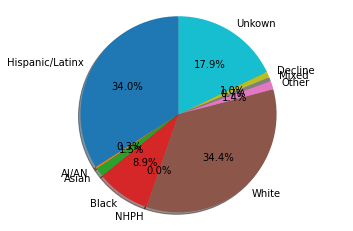

In [4]:
# print (df.loc[21, 'All Tests'])
labels = 'Hispanic/Latinx', 'AI/AN', 'Asian', 'Black', 'NHPH', 'White', 'Other', 'Mixed', 'Decline', 'Unkown'
sizes = [df.loc[21, 'Confirmed Cases'], df.loc[22, 'Confirmed Cases'], df.loc[23, 'Confirmed Cases'], df.loc[24, 'Confirmed Cases'], df.loc[25, 'Confirmed Cases'], df.loc[26, 'Confirmed Cases'], df.loc[27, 'Confirmed Cases'], df.loc[28, 'Confirmed Cases'], df.loc[29, 'Confirmed Cases'], df.loc[30, 'Confirmed Cases']]
explode = (0,0,0,0,0,0,0,0,0,0)
f1, a1 = plt.subplots()
a1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
a1.axis('equal')


## Now, let's do the same thing but to create a data frame for the case, death, and hospitalization totals

In [5]:
# Let's get the URL specific to the tab that has the totals, this is the 'Summary' tab. 
# Just like earlier, let's create our dataframe by reading this CSV

RhodeIslandTotalsUrl = "https://docs.google.com/spreadsheets/d/1c2QrNMz8pIbYEKzMJL7Uh2dtThOJa2j1sSMwiDo5Gz4/export?format=csv&gid=264100583"
RhodeIslandTotals = pd.read_csv(RhodeIslandTotalsUrl)

# The dataframe as it stands now has lots of data we don't need,
# let's clean it so we only display totals for cases, deaths, and hospitilizations

RhodeIslandTotals = RhodeIslandTotals.iloc[9:,]
RhodeIslandTotals = RhodeIslandTotals.drop([10,11,13,15,16,17,18,19,20,21,22,23,25,26])

#let's rename the rows to make it easier to read
RhodeIslandTotals.rename(index = {'Total deaths':'TOTAL DEATHS'}, inplace = True)
RhodeIslandTotals = RhodeIslandTotals.replace(['Cumulative people tested (one count per person)'],'Total People Tested')
RhodeIslandTotals = RhodeIslandTotals.replace(['Cumulative hospital admissions'],'Total Hospitalizations')
RhodeIslandTotals = RhodeIslandTotals.replace(['Cumulative people who tested positive (counts first positive lab per person)'],'Total Cases')

RhodeIslandTotals

,Last updated:,11/12/2020
9,Total Cases,40764
12,Total People Tested,474414
14,Total Hospitalizations,3701
24,Total deaths,1250


## Let's plot some trends and get some other facts about the data (data about the data! 😮)

In [6]:
RhodeIslandTrendsURl = "https://docs.google.com/spreadsheets/d/1c2QrNMz8pIbYEKzMJL7Uh2dtThOJa2j1sSMwiDo5Gz4/export?format=csv&gid=1592746937"
RhodeIslandTrends = pd.read_csv(RhodeIslandTrendsURl)

#Display the entire data frame 
RhodeIslandTrends

,Date,Daily number of positive tests (may count people more than once),3-day average of daily number of positive tests (may count people more than once),Cumulative positive tests (may count people more than once),Daily number of negative tests (may count people more than once),Cumulative negative tests (may count people more than once),Daily total tests completed (may count people more than once),Cumulative total tests completed (may count people more than once),New people who tested positive (counts first positive lab per person),3-day average of new people who tested positive (counts first positive lab per person),...,New hospital discharges,Cumulative hospital discharges,Hospital deaths,Cumulative hospital deaths,Currently hospitalized,3-day average of currently hospitalized,Currently in ICU,Currently vented,Date of death,Total deaths
0,2/27/2020,0,--,0,0,0,0,0,0,--,...,0.0,0.0,0.0,0.0,1.0,--,0.0,0.0,0,0
1,2/28/2020,0,--,0,0,0,0,0,0,--,...,0.0,0.0,0.0,0.0,1.0,--,1.0,0.0,0,0
2,2/29/2020,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0,0
3,3/1/2020,2,1,2,2,2,4,4,2,1,...,0.0,0.0,0.0,0.0,1.0,1,1.0,1.0,0,0
4,3/2/2020,0,1,2,1,3,1,5,0,1,...,0.0,0.0,0.0,0.0,2.0,1,2.0,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,11/7/2020,606,714,49200,13245,1204553,13851,1253753,570,647,...,24.0,2965.0,1.0,414.0,222.0,216,27.0,17.0,1,1233
255,11/8/2020,338,573,49538,3964,1208517,4302,1258055,319,529,...,25.0,2990.0,1.0,415.0,224.0,221,26.0,18.0,3,1236
256,11/9/2020,789,578,50327,8672,1217189,9461,1267516,744,544,...,32.0,3022.0,2.0,417.0,225.0,224,25.0,17.0,3,1239
257,11/10/2020,1062,730,51389,12867,1230056,13929,1281445,969,677,...,30.0,3052.0,0.0,417.0,232.0,227,28.0,17.0,5,1244


In [7]:
# RI doesn't just track the running total, but also new cases per day, let's show this table and plot this

RhodeIslandNewTotals = RhodeIslandTrends[['Date', 'Daily number of positive tests (may count people more than once)']]
RhodeIslandNewTotals

,Date,Daily number of positive tests (may count people more than once)
0,2/27/2020,0
1,2/28/2020,0
2,2/29/2020,0
3,3/1/2020,2
4,3/2/2020,0
...,...,...
254,11/7/2020,606
255,11/8/2020,338
256,11/9/2020,789
257,11/10/2020,1062


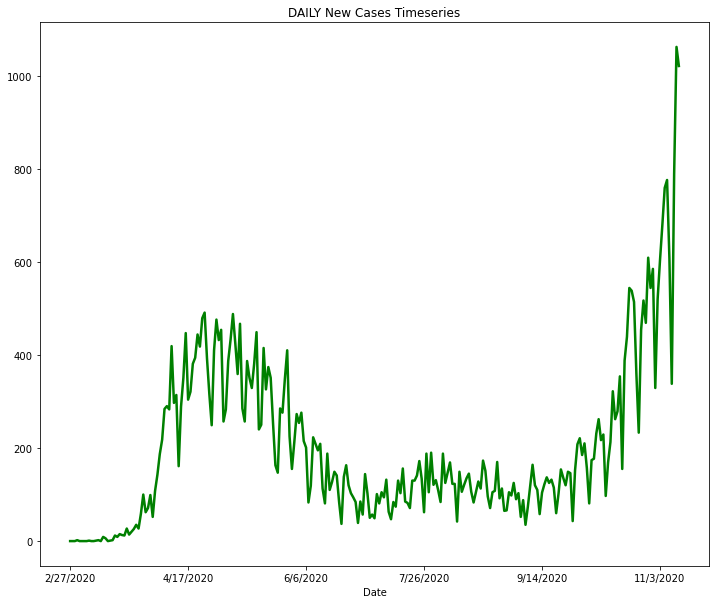

In [8]:
# We can even make a line graph to track the new cases per day!
RhodeIslandNewTotals.set_index('Date')['Daily number of positive tests (may count people more than once)'].plot(figsize=(12, 10), title='DAILY New Cases Timeseries'
                                                                        ,linewidth=2.5, color='green')

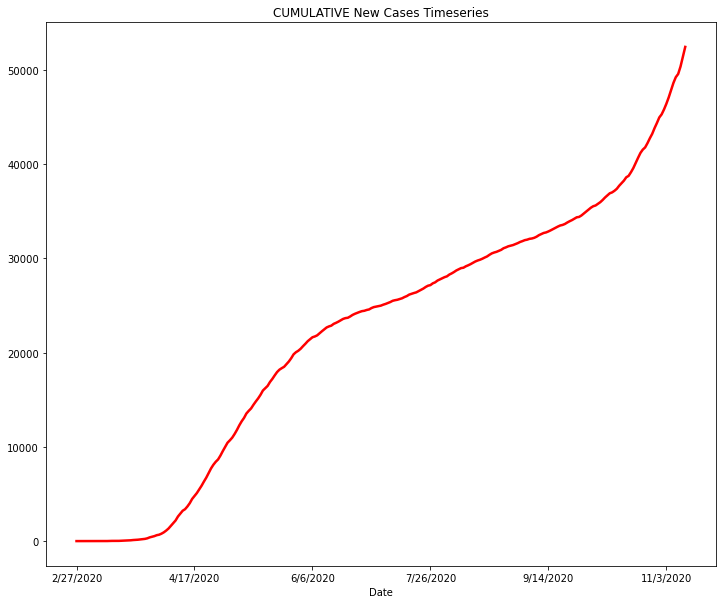

In [9]:
# or, we can plot the cumulative new cases too!
# RhodeIslandTrends
RhodeIslandCumulativeTotals = RhodeIslandTrends[['Date', 'Cumulative positive tests (may count people more than once)']]
RhodeIslandCumulativeTotals.set_index('Date')['Cumulative positive tests (may count people more than once)'].plot(figsize=(12, 10), title='CUMULATIVE New Cases Timeseries'
                                                                        ,linewidth=2.5, color='red')

In [10]:
# Let's plot other important data to track for abnormalities, we'll plot both new deaths and new hospitilizations per day
RhodeIslandNewHospitalTotals = RhodeIslandTrends[['Date', 'New hospital admissions']]
RhodeIslandNewHospitalTotals
# RhodeIslandNewHospitalTotals.set_index('Date')['New hospital admissions'].plot(figsize=(12, 10), title='DAILY New Hospital Admissions Timeseries'
#                                                                         ,linewidth=2.5, color='blue')

#visualizing standard deviations
#have an upper and lower bound (similar to regressions), plot stdev, use a 20-day window 
#

,Date,New hospital admissions
0,2/27/2020,1.0
1,2/28/2020,0.0
2,2/29/2020,0.0
3,3/1/2020,0.0
4,3/2/2020,1.0
...,...,...
254,11/7/2020,31.0
255,11/8/2020,28.0
256,11/9/2020,35.0
257,11/10/2020,37.0


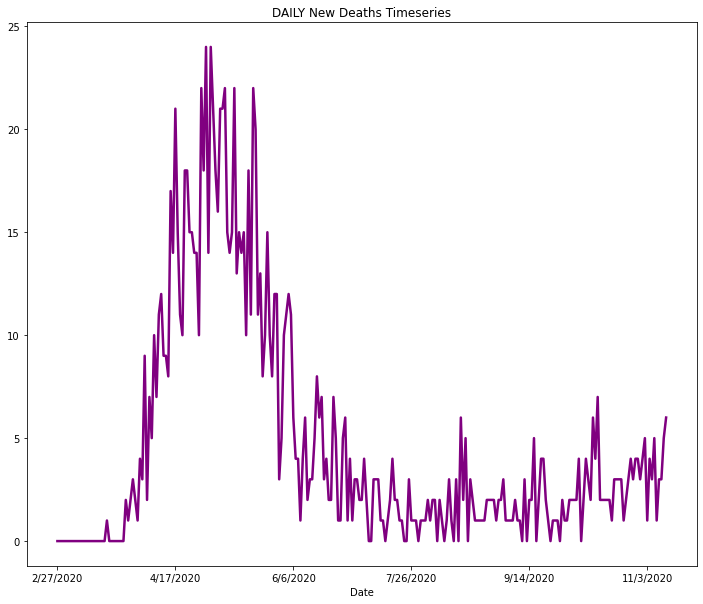

In [11]:
RhodeIslandNewDeathTotals = RhodeIslandTrends[['Date', 'Date of death']]
RhodeIslandNewDeathTotals.set_index('Date')['Date of death'].plot(figsize=(12, 10), title='DAILY New Deaths Timeseries'
                                                                        ,linewidth=2.5, color='purple')

In [12]:
#https://docs.google.com/spreadsheets/d/1c2QrNMz8pIbYEKzMJL7Uh2dtThOJa2j1sSMwiDo5Gz4export?format=csv&gid=1074078949
RhodeIslandRaceTrendsUrl = "https://docs.google.com/spreadsheets/d/1c2QrNMz8pIbYEKzMJL7Uh2dtThOJa2j1sSMwiDo5Gz4/export?format=csv&gid=1074078949"
RhodeIslandRaceTrends = pd.read_csv(RhodeIslandRaceTrendsUrl)
RhodeIslandRaceTrends

,Number of COVID-19 Cases by Race and Ethnicity and Week of First Positive Test Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Source: Rhode Island Department of Health (RID...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Last updated:,11/11/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NOTES: Congregate setting residents are includ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Week of Result Date,Hispanic or Latino†,American Indian or Alaska Native*,Asian*,Black or African American*,Native Hawaiian or Other Pacific Islander,White*,Other race*,Multiple race*,Declined,Unknown or pending further information,Total
6,3/1-3/7 (Week 10),0,0,0,0,0,<5,<5,0,0,0,<5
7,3/8-3/14 (Week 11),<5,0,<5,0,0,9,<5,0,0,<5,16
8,3/15-3/21 (Week 12),5,0,0,<5,0,26,0,0,0,33,66
9,3/22-3/28 (Week 13),26,<5,<5,17,0,85,<5,0,<5,78,213


In [13]:

# RhodeIslandRaceTrends.set_index('Number of COVID-19 Cases by Race and Ethnicity and Week of First Positive Test Date')['Date of death'].plot(figsize=(12, 10), title='DAILY New Deaths Timeseries'
#                                                                         ,linewidth=2.5, color='purple')
# RhodeIslandTotals = RhodeIslandTotals.iloc[9:,]


RhodeIslandRaceTrends=RhodeIslandRaceTrends.iloc[5:,]
RhodeIslandRaceTrends

,Number of COVID-19 Cases by Race and Ethnicity and Week of First Positive Test Date,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
5,Week of Result Date,Hispanic or Latino†,American Indian or Alaska Native*,Asian*,Black or African American*,Native Hawaiian or Other Pacific Islander,White*,Other race*,Multiple race*,Declined,Unknown or pending further information,Total
6,3/1-3/7 (Week 10),0,0,0,0,0,<5,<5,0,0,0,<5
7,3/8-3/14 (Week 11),<5,0,<5,0,0,9,<5,0,0,<5,16
8,3/15-3/21 (Week 12),5,0,0,<5,0,26,0,0,0,33,66
9,3/22-3/28 (Week 13),26,<5,<5,17,0,85,<5,0,<5,78,213
10,3/29-4/4 (Week 14),85,<5,<5,56,0,256,5,<5,<5,216,625
11,4/5-4/11 (Week 15),502,8,28,165,0,764,10,5,13,335,"1,830"
12,4/12-4/18 (Week 16),743,11,24,219,0,604,10,10,24,290,"1,935"
13,4/19-4/25 (Week 17),946,10,23,278,0,720,21,14,37,478,"2,527"
14,4/26-5/2 (Week 18),748,6,42,230,0,480,18,7,26,435,"1,992"


In [14]:

# RhodeIslandRaceTrends.set_index('Number of COVID-19 Cases by Race and Ethnicity and Week of First Positive Test Date')['Unnamed: 1'].plot(figsize=(12, 10), title='Trends by Race'
#                                                                         ,linewidth=2.5, color='purple')

